In [1]:
import torch
import torch.nn.functional as F
import numpy as np

from torch.utils.data import Dataset, DataLoader 
from tqdm import tqdm

from dataloader import *

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
torch.autograd.set_detect_anomaly(True)

n_nodes = 16

#batch_size = 16        # Note: in og CML trajectory length == batch_size; in POCML this should be decoupled
state_dim = 100
random_feature_dim = 1000
epochs = 50
n_obs = 16

trajectory_length = 8   # numer of node visits in a trajectory
num_desired_trajectories= 100

# choose env from "random", "small world" or "dead ends"
env = GraphEnv(size=n_nodes, n_items=n_obs, env='random', batch_size=trajectory_length, num_desired_trajectories=num_desired_trajectories, unique = True)

dataset = RandomWalkDataset(env.adj_matrix, trajectory_length, num_desired_trajectories, n_obs)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

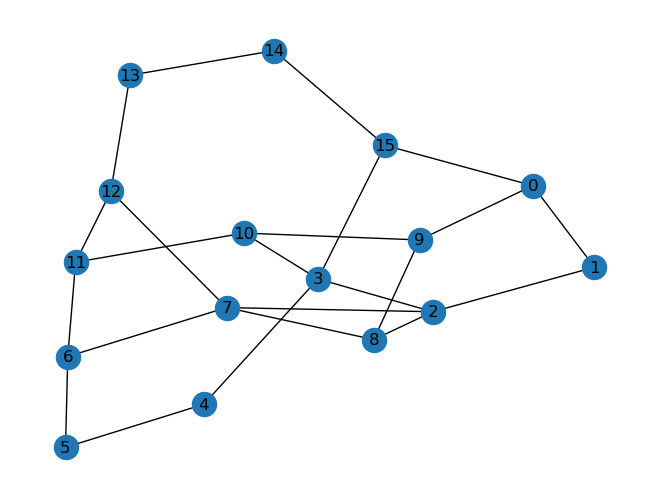

number of actions: 46
trajectory:
tensor([[[ 7,  6,  4],
         [ 4,  7,  7],
         [ 7,  6,  4],
         [ 4, 10,  6],
         [ 6, 30,  4],
         [ 4, 39,  0],
         [ 0, 38,  4]]])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])


In [3]:
adj = env.adj_matrix

# Assuming you have the adjacency matrix stored in the variable "adj"
G = nx.from_numpy_array(adj.numpy().astype(float))

# Draw the graph using seaborn
# sns.set()
seed = 31 # Consistent graph shape across runs
pos = nx.spring_layout(G, seed=seed)
nx.draw(G, pos = pos, with_labels=True)
# Show the plot
plt.show()

print(f"number of actions: {env.n_actions}")

print("trajectory:")
for trajectory in dataloader:
    print(trajectory)
    break

print(env.items)

In [4]:
# Our code
import random
from trainer import POCMLTrainer
from model import POCML

# Setting random seed for consistent behavior
train_seed = 72 - 3
random.seed(train_seed)
torch.manual_seed(train_seed)
torch.cuda.manual_seed(train_seed)
torch.backends.cudnn.deterministic = True
random.seed(train_seed)
np.random.seed(train_seed)

model = POCML(n_obs = env.n_items,
                n_states = env.size,
                n_actions = env.n_actions,
                state_dim = state_dim,
                random_feature_dim = random_feature_dim)
    
trainer = POCMLTrainer(model=model, 
                       train_loader = dataloader,)

loss_record = np.array(trainer.train(epochs)).reshape(epochs,-1)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

/home/zhuowen/project/GCML/model.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = F.softmax(self.beta * (phi_Q.conj().T @ state).real)
/home/zhuowen/project/GCML/model.py:109: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = F.softmax(self.beta * (phi_Q.conj().T @ state).real)


In [5]:
loss_record

array([[2.21546826e+03, 8.52486719e+03, 1.47033857e+04, ...,
        1.86147226e+09, 1.91543104e+09, 1.86131622e+09],
       [2.76896509e+03, 4.45329961e+04, 8.44763516e+04, ...,
        1.88330189e+10, 3.66631977e+10, 1.88330414e+10],
       [2.79105225e+03, 5.09709766e+04, 9.69381562e+04, ...,
        1.91895798e+10, 1.91897948e+10, 3.84522404e+10],
       ...,
       [2.40789551e+03, 2.19779648e+04, 4.06671562e+04, ...,
        1.46409851e+10, 0.00000000e+00, 1.46409851e+10],
       [2.40062915e+03, 0.00000000e+00, 3.91950938e+04, ...,
        1.03099433e+10, 0.00000000e+00, 1.38426542e+10],
       [2.39338501e+03, 2.04228105e+04, 3.76480430e+04, ...,
        1.26509527e+10, 1.42104054e+10, 1.26509548e+10]])

Text(0.5, 0, 'Number of weight updates')

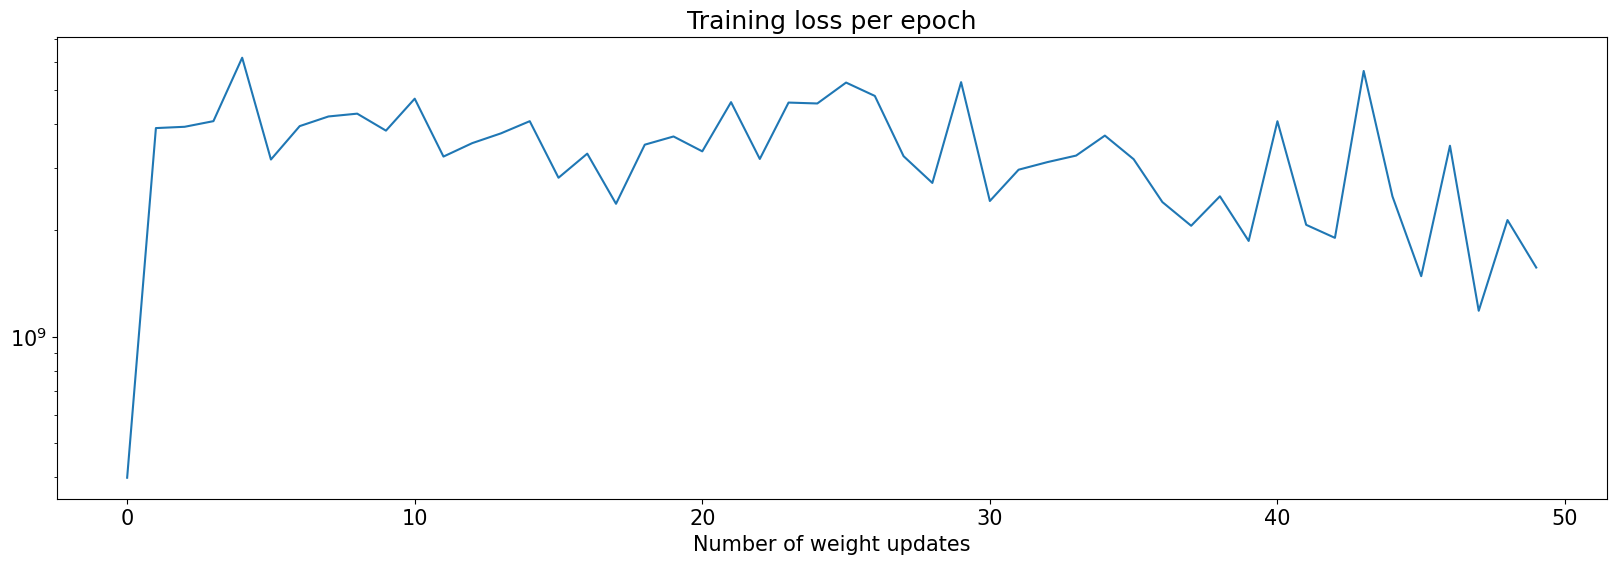

In [6]:
# our trainer loss plot - flattened 

plt.rcParams['font.size'] = 15
plt.figure(figsize=(20, 6))
plt.plot(np.mean(loss_record, axis=1))
plt.yscale('log')
plt.title('Training loss per epoch')
plt.xlabel('Number of weight updates')

In [ ]:
# CML's model

def test_model(model, env, print_results=True):
    N_nodes = model.o_size
    dis = []
    D_dis = []
    N_goal = 1000
    adj_matrix_tensor = env.adj_matrix.to(device)
    graph = nx.from_numpy_matrix(env.adj_matrix.cpu().numpy(), create_using=nx.DiGraph())
    for i in range(N_goal):
        start_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        goal_idx = torch.randint(N_nodes, (1,)).to(device)[0]
        with torch.no_grad():
            steps, o_record = model.plan(start_idx, goal_idx, env, False)
        D_path = nx.shortest_path(graph, source=int(start_idx.cpu()), target=int(goal_idx.cpu()))
        D_steps = len(D_path) - 1
        dis.append(steps)
        D_dis.append(D_steps)

    # Convert lists to tensors and move them to GPU
    dis = torch.tensor(dis).float().to(device)
    D_dis = torch.tensor(D_dis).float().to(device)
    mask = dis != (N_nodes-1)
    mean_CML = torch.mean(dis).item()
    std_CML = torch.std(dis).item()
    mean_Dij = torch.mean(D_dis).item()
    std_Dij = torch.std(D_dis).item()
    if print_results:
        print('CML steps:', str(mean_CML)[:6], ', Success Rate:', str((mask.sum() / N_goal * 100).item())[:6] + '%',
          ', Dij steps:', str(mean_Dij)[:6], ', Percentage worse:', str((mean_CML / mean_Dij - 1) * 100)[:6] + '%')
        print('CML std: ', str(std_CML)[:6], ' Dij std: ', str(std_Dij)[:6])
    else:
        return mean_CML
# 